# Closed loop stability

Stability of closed loop control systems appears to be easy to determine. We can just calculate the closed loop transfer function and invert the Laplace transform.

In [1]:
import sympy
sympy.init_printing()

In [2]:
%matplotlib inline

In [3]:
s = sympy.Symbol('s')

In [4]:
K_c, t = sympy.symbols('K_c, t', positive=True)

These are the systems from Example 10.4 in Seborg et al

In [5]:
G_c = K_c
G_v = 1/(2*s + 1) 
G_p = G_d = 1/(5*s + 1)
G_m = 1/(s + 1)

In [6]:
K_m = sympy.limit(G_m, s, 0)

In [7]:
forward = G_c*G_v*G_p
backward = G_m

G_CL = K_m*forward/(1 + forward*backward)

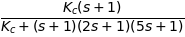

In [8]:
sympy.simplify(G_CL)

In [9]:
y = G_CL/s

Now for the moment of truth. Uncomment the next line if you have a lot of time on your hands...

In [10]:
#yt = sympy.inverse_laplace_transform(y, s, t)

So that didn't really work as we expected. Can we at least calculate the roots of the denominator?

In [11]:
ce = sympy.denom(G_CL.simplify())
ce.expand()

In [12]:
roots = sympy.solve(ce, s)

OK, that approach works, but is limited in the analytic case to 4th order polynomials

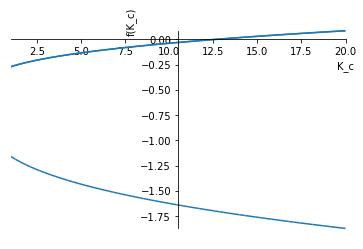

In [13]:
sympy.plot(*[sympy.re(r) for r in roots], (K_c, 1, 20))

We can see that one root gets a positive real part around $K_c=12.5$

# Using the control library
We quickly run out of SymPy's abilities when calculating closed loop transfer functions. Let's try to do it with the control library instead:

In [14]:
import control
import numpy
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
s = control.tf([1, 0], [1])

In [16]:
G_v = 1/(2*s + 1) 
G_p = G_d = 1/(5*s + 1)
G_m = 1/(s + 1)
K_m = 1

In [17]:
from tbcontrol.loops import feedback

In [18]:
def closedloop(K_c):
    G_c = K_c

    G_CL = K_m*feedback(G_c*G_v*G_p, G_m)
    return G_CL

In [19]:
closedloop(2)


           20 s^3 + 34 s^2 + 16 s + 2
------------------------------------------------
100 s^5 + 240 s^4 + 209 s^3 + 103 s^2 + 29 s + 3

In [20]:
from ipywidgets import interact

In [21]:
smootht = numpy.linspace(0, 20)

In [22]:
loop = G_v*G_p*G_m

/Users/alchemyst/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


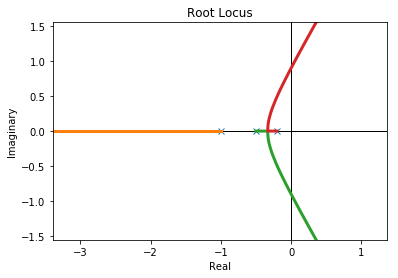

In [23]:
_ = control.rlocus(loop)

In [24]:
def response(K_C):
    G_CL = closedloop(K_C)
    poles = G_CL.pole()
    plt.plot(*control.step_response(G_CL, smootht))
    _ = control.rlocus(loop)
    plt.scatter(poles.real, poles.imag, color='red')

In [25]:
interact(response, K_C=(1., 20.))

interactive(children=(FloatSlider(value=10.5, description='K_C', max=20.0, min=1.0), Output()), _dom_classes=(…

<function __main__.response(K_C)>

Now, the step response is calculated quickly enough that we can interact with the graphics using the slider!

## Direct substitution

From our exploration above it is clear there is a zero of the characteristic equation at $K_C \approx 13$. Let's solve for this numerically:


In [26]:
def chareq(x):
    Kc, omega = x
    s = 1j*omega
    ce = 1 + Kc*loop
    ce_of_s = ce(s)
    return ce_of_s.real, ce_of_s.imag

In [27]:
import scipy.optimize

In [28]:
scipy.optimize.fsolve(chareq, [13, 1])

array([12.6       ,  0.89442719])

How can we determine stability without calculating the roots? See the [next notebook](Sympy%20Routh%20Array.ipynb).